I’ve been following the topic of automatic differentiation for quite a few years now, without ever managing to dive deep into it.

Recent readings have prompted me to try again.

A very quick introduction to the topic is to say that there are many ways of computing derivatives:

- you could to it manually (by hand, applying the rules of calculus)
- you could do it symbolically (using a computer algebra system, e.g. Sympy in Python)
- using finite differences (this is a numerical approximation relying on Taylor expansions)
- using automatic differentiation


Looking deeper into automatic differentiation, two topics usually come up:

- forward mode (often said to be similar to how you usually apply the chain rule in calculus)
- reverse mode (of which a special case is the backpropagation algorithm typically used when training neural networks)

Today, I’d like to follow a paper proposing an implementation of the forward mode: "Introduction to Automatic Differentiation and MATLAB Object-Oriented Programming" by Richard Neidinger, which can be found at https://www.neidinger.net/SIAMRev74362.pdf.

The paper proposes to compute the derivative, in an automatic differentiation way, of the function $y = x \sin(x^2)$ at $x=3$ using an implementation of value and derivative (*valder*).

To reach this goal, we need the following building blocks:

- write a class that allows representing a *valder*
- make it able to operate on functions $x \rightarrow x^2$, $x \rightarrow \sin(x)$
- make it able to operate on the product of two *valder*

Let’s get started.

# A class to represent a *valder*

In [1]:
class Valder:
    def __init__(self, val=None, der=None):
        if val is None:
            raise RuntimeError("User should provide at least one value to init Valder class!")
        else:
            if der is None:
                # shorthand for a constant value
                self.val = val
                self.der = 0
            else:
                # general case
                self.val = val
                self.der = der
                
    def __repr__(self):
        return f"Valder(val={self.val}, der={self.der})"

Let’s try this out.

In [2]:
Valder(1)

Valder(val=1, der=0)

In [3]:
Valder(1, 1)

Valder(val=1, der=1)

Now, you’re wondering, what does the `der` part mean? Quite simply, it is the derivative, with respect to $x$ of the expression represented.

Imagine we want to represent the function $f(x) = x$ at x=1. It’s value would be 1 and its derivative would also be 1.

In [4]:
# this is f(x)=x at x=1
Valder(1, 1)

Valder(val=1, der=1)

With that being said, let’s move on to the second item on the list.

# Make it operate on the square function

The chain rule has a very cool property that makes it able to "propagate" things along a graph.

When we write the derivative of $f(g(x))$, we could write it either:

- $g'(x) \cdot f'(g(x))$
- or $f'(g(x)) \cdot g'(x)$

In this context, the second way of writing is the more relevant, because it allows to defer the computation of $g'(x)$ to a later moment. To illustrate what I mean, let’s pretend we want to compute the derivative of $\exp(\sin(\sin(x)))$ w.r.t. to $x$. Applying the second formula we can say in a first step that we first derivate the exponential, which yields an exponential again and then multiply it by the derivative of $\sin(\sin(x))$. This is very handy when writing on pen and paper because it means we can write the terms later on. 

There is similarity with this idea when we compute the derivative of the square function using a `Valder`.

We know that $(x^2)' = 2 x$. But what if instead of $x$ we put in a function in the square operator?

In that case, $$(f^2)' = \dfrac{df ^2}{df} \cdot df = 2 f f'$$

The above expression means that if we know the value of $f'$, we can know compute the value of $(f^2)'$ just by multiplying it with $2 f$. This is exactly the recipe we will apply to the `der` part of the `Valder` making a square!

In [5]:
def square(valder):
    x, dx = valder.val, valder.der
    return Valder(x * x, 2 * x * dx)

Let’s test this:

In [6]:
x = Valder(1, 1) 
square(x) # f(x) = x^2 at x = 1

Valder(val=1, der=2)

In [7]:
x = Valder(3, 1) 
square(x) # f(x) = x^2 at x = 3

Valder(val=9, der=6)

# The sin function

The implementation for the sinus function is quite similar, based on 

$$
\sin(f)' = \frac{d \sin(f)}{ df } df = \cos(f) df 
$$

In [8]:
from math import sin as math_sin, cos as math_cos

def sin(valder):
    x, dx = valder.val, valder.der
    return Valder(math_sin(x), math_cos(x) * dx)

Again, let’s see what it gives.

In [9]:
x = Valder(0, 1)
sin(x) # sin(0)=0, cos(0)=1

Valder(val=0.0, der=1.0)

# Make it able to operate on the product of two valder

Now the last step is to make our framework work is to implement the operation that computes a derivative of a product.

The math is that $(f g) ' = f'g + f g'$. 

In [10]:
def prod(valder1, valder2):
    x, dx = valder1.val, valder1.der
    y, dy = valder2.val, valder2.der
    
    return Valder(x * y, dx * y + x * dy)

In [11]:
x = Valder(2, 1)

prod(x, x), square(x) # x*x and x^2 should give same results

(Valder(val=4, der=4), Valder(val=4, der=4))

# Combining things and computing a complex derivative

We can now compute the derivative of $y = x \sin(x^2)$ at $x=3$.

In [12]:
x = Valder(3, 1)
prod(x, sin(square(x)))

Valder(val=1.2363554557252698, der=-15.988226228682427)

Let’s check our result with finite differences:

In [13]:
import numpy as np
eps = 1e-8

3 * np.sin(3**2), ((3 + eps) * np.sin((3 + eps)**2) - 3 * np.sin(3**2)) / eps

(1.2363554557252698, -15.988226431673525)

Now, that’s a very satisfying agreement :)

# Using our system to implement Newton’s method

With that first part in place, the paper then introduces the following function $f(x) = e^{-\sqrt{x}} \sin(x \ln(1 + x^2))$. 

Let’s implement the missing parts so that we can plot the function and its derivative over a range of values.

In [14]:
from math import exp as math_exp, log as math_log, sqrt as math_sqrt

def exp(valder):
    x, dx = valder.val, valder.der
    return Valder(math_exp(x), math_exp(x) * dx)

def ln(valder):
    x, dx = valder.val, valder.der
    return Valder(math_log(x), 1/x * dx)

def sqrt(valder):
    x, dx = valder.val, valder.der
    return Valder(math_sqrt(x), 1/(2 * math_sqrt(x)) * dx)

def add(valder1, valder2):
    x, dx = valder1.val, valder1.der
    y, dy = valder2.val, valder2.der
    
    return Valder(x + y, dx + dy)

def f_and_df(a):
    x = Valder(a, 1)
    u = exp(prod(Valder(-1), sqrt(x)))
    v = sin(prod(x, ln(add(Valder(1.), square(x)))))
    y = prod(u, v)
    return y.val, y.der

f_and_df(1.)

(0.2350607172604515, 0.36160858251472927)

Let’s plot this:

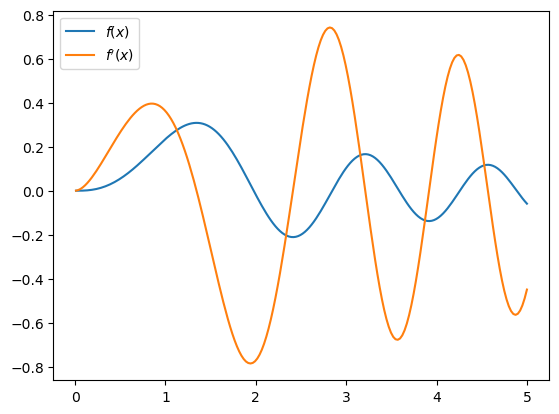

In [15]:
import matplotlib.pyplot as plt

x = np.linspace(0.01, 5, num=200)

fig, ax = plt.subplots()
ax.plot(x, [f_and_df(xx) for xx in x], label=['$f(x)$', "$f'(x)$"])
ax.legend();

We can now use Newton’s method to compute a zero of this function closest to 5:

In [16]:
def newton(a):
    delta = 1
    while abs(delta) > .000001:
        f, df = f_and_df(a)
        delta = f / df 
        a = a - delta
    return a

newton(5)

4.8870559674555425

We could also use this to compute the other zeros in the graph:

In [17]:
newton(1), newton(2), newton(3), newton(4)

(1.341722663023364e-06,
 1.9758175546652457,
 2.845630206720267,
 3.5854013034702708)

# TL;DR

In this post, we have implemented the basics of an automatic differentiation engine using the forward accumulation mode. Key features are that this mode operates directly on the values (think, floating point numbers) of the functions we are using and does not introduce any approximations (when compared to finite differences for example!).

Of course this only touches a part of the iceberg, the next step would be to investigate the so-called reverse mode.

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240206_AutoDiffValDer.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240206_AutoDiffValDer.ipynb).*